In [31]:
import collections

Sample = collections.namedtuple('Sample', ['timestamp', 'gnss_easting', 'gnss_northing', 'odom_drive', 'odom_steer', 'lidar'])

In [30]:
import csv
def read_log(file):
  reader = csv.reader(file)
  result = []
  for line in reader:
    result.append(Sample(
        float(line[0]), 
        float(line[1]), 
        float(line[2]), 
        float(line[3]), 
        float(line[4]), 
        list(map(lambda i: (float(line[i]), float(line[i + 1])), range(5, len(line), 2)))
        ))
  return result

In [32]:
import math
WHEELBASE_LENGTH = 0.32
Pose = collections.namedtuple('Pose', ['x', 'y', 'theta'])
def parse_odometry(log):
  poses = [Pose(0.0, 0.0, 0.0)]
  prev_samp = log[0]
  for samp in log[1::]:
    # https://thomasfermi.github.io/Algorithms-for-Automated-Driving/Control/BicycleModel.html
    dt = samp.timestamp - prev_samp.timestamp
    poses.append(
      Pose(
        poses[-1].x + (samp.odom_drive * dt * math.cos(poses[-1].theta)), 
        poses[-1].y + (samp.odom_drive * dt * math.sin(poses[-1].theta)), 
        poses[-1].theta + (samp.odom_drive * dt * math.tan(samp.odom_steer) * (1 / WHEELBASE_LENGTH))
        )
      )
    prev_samp = samp
  return poses


In [33]:
Trans = collections.namedtuple('Trans', ['x', 'y'])

def parse_lidar(path, log):
  detections = []
  for (samp, pose) in zip(log, path):
    for (i, lidar) in enumerate(samp.lidar):
      if lidar[0] == 0 and lidar[1] == 0:
        continue
      theta = -(pose.theta + math.atan2(lidar[1], lidar[0]))
      x = math.cos(theta) * math.sqrt(lidar[0] ** 2 + lidar[1] ** 2)
      y = math.sin(theta) * math.sqrt(lidar[0] ** 2 + lidar[1] ** 2)
      detections.append(
        Trans(
          pose.x + x,
          pose.y + y
        )
    )
  return detections

In [155]:
import numpy as np


GRID_RESOLUTION = 0.1
def generate_count_grid(detections, poses):
    min_x = min(map(lambda d: d[0], detections))
    min_y = min(map(lambda d: d[1], detections))
    max_x = max(map(lambda d: d[0], detections))
    max_y = max(map(lambda d: d[1], detections))
    print(f"x [{min_x}, {max_x}] y [{min_y}, {max_y}]")
    num_cols, num_rows = (int((max_x - min_x) / GRID_RESOLUTION), int((max_y - min_y) / GRID_RESOLUTION))
    print(f"{num_rows} rows by {num_cols} cols")
    
    # Initialize the grid with zeros
    grid = [[0 for _ in range(num_cols)] for _ in range(num_rows)]

    # Count poses in the grid
    for pose in detections:
        x, y = pose
        # Convert pose to grid cell index based on resolution
        row = int(((y - min_y) / (max_y - min_y)) * num_rows)
        col = int(((x - min_x) / (max_x - min_x)) * num_cols)
        
        if 0 <= row < num_rows and 0 <= col < num_cols:
            grid[row][col] += 1
        # else:
            # print(f"Pose {pose} is out of grid bounds.")

    # reweight based on possible detections
    # generate a grid with counts of potential times we saw it
    cand_grid = [[0 for _ in range(num_cols)] for _ in range(num_rows)]
    for pose in poses:
        for row in range(len(cand_grid)):
            for col in range(len(cand_grid[row])):
                x = ((1 - (float(col) / num_cols)) * min_x) + ((float(col) / num_cols) * max_x)
                y = ((1 - (float(row) / num_rows)) * min_y) + ((float(row) / num_rows) * max_y)
                if (pose.x - x) ** 2 + (pose.y - y) ** 2 < 10 ** 2:
                    cand_grid[row][col] += 1
    # generate a grid with [0-1] weights instead of counts
    weight_grid = [[0.0 for _ in range(num_cols)] for _ in range(num_rows)]
    for row in range(len(weight_grid)):
        for col in range(len(weight_grid[row])):
            if cand_grid[row][col] != 0:
                weight_grid[row][col] = (float(grid[row][col]) / cand_grid[row][col])
    # print(weight_grid)
    return (weight_grid, (min_x, max_x, min_y, max_y))

[Sample(timestamp=0.0, gnss_easting=0.15000000000000002, gnss_northing=0.0, odom_drive=0.75, odom_steer=0.27998898059277977, lidar=[(0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.6285289824346638, 1.1758950191311401), (0.4638587058970786, 1.1198539788015598), (0.31667419336850433, 1.0439349117078642), (0.21282580583577634, 1.0699475786217059), (0.10692778945042992, 1.0856560654605782), (6.679891631712835e-17, 1.0909090909090908), (-0.10692778945042979, 1.0856560654605785), (-0.2128258058357762, 1.0699475786217059), (-0.3518602148538935, 1.1599276796754048), (-0.5102445764867863, 1.2318393766817157), (-0.0, 0.0), (-0.0, 0.0), (-0.0, 0.0), (-0.0, 0.0), (-0.0, 0.0), (-0.0, 0.0), (-0.0, 0.0), (-0.0, 0.0), (-0.0, 0.0), (-0.0, 0.0), (-0.0, 0.0), (-0.0, 0.0), (-0.0, -0.0), (-0.0, -0.0), (-0.0, -0.0), (-0.0, -0.0), (-0.0, -0.0), (-0.0, -0.0), (-0.0, -0.0), (-0.0, -0.0), (-0.9227538678743941, -1.124378841254

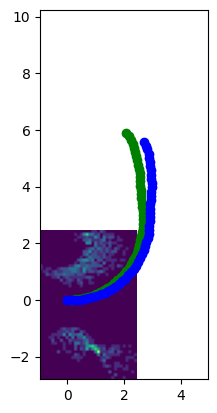

In [156]:
import matplotlib.pyplot as plt
test_log = read_log(open('./test_log.log', 'r'))
print(test_log)
odometry = parse_odometry(test_log)
print(odometry)
detections = parse_lidar(odometry, test_log)
print(detections)

# show odo
fig, ax1 = plt.subplots()
# ax1.set_ymargin(1.0)
# ax1.set_xmargin(1.0)
omap = generate_count_grid(detections, odometry)
# for r in omap[0]:
#   print(str(r) + "\n")
ax1.imshow(omap[0], extent=omap[1], origin='lower')
ax1.scatter(list(map(lambda samp: samp.gnss_easting, test_log)), list(map(lambda samp: samp.gnss_northing, test_log)), color='green')
# ax1.scatter(list(map(lambda trans: trans.x, detections)), list(map(lambda trans: trans.y, detections)), color='red')
ax1.scatter(list(map(lambda pose: pose.x, odometry)), list(map(lambda pose: pose.y, odometry)), color='blue')
ax1.margins(0.5)
ax1.set_aspect('equal')
plt.show()